## 1. Inspecting transfusion.data file
<p><img src="https://media-eng.dhakatribune.com/uploads/2017/04/Blood-Transfusion_Bigstock.jpg" style="float: right;" alt="A pictogram of a blood bag with blood donation written in it" width="500"></p>
<p>Blood transfusion saves lives - from replacing lost blood during major surgery or a serious injury to treating various illnesses and blood disorders. Ensuring that there's enough blood in supply whenever needed is a serious challenge for the health professionals. According to <a href="https://www.webmd.com/a-to-z-guides/blood-transfusion-what-to-know#1">WebMD</a>, "about 5 million Americans need a blood transfusion every year".</p>
<p>Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive. We want to predict whether or not a donor will give blood the next time the vehicle comes to campus.</p>
<p>The data is stored in <code>datasets/transfusion.data</code> and it is structured according to RFMTC marketing model (a variation of RFM). We'll explore what that means later in this notebook. First, let's inspect the data.</p>

In [1]:
# Print out the first 5 lines from the transfusion.data file
!head -n 5 datasets/transfusion.data

## 2. Loading the blood donations data
<p>We now know that we are working with a typical CSV file (i.e., the delimiter is <code>,</code>, etc.). We proceed to loading the data into memory.</p>

In [2]:
# Import pandas
import pandas as pd

# Read in dataset
transfusion = pd.read_csv('datasets/transfusion.data')

# Print out the first rows of our dataset
transfusion.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## 3. Inspecting transfusion DataFrame
<p>Let's briefly return to our discussion of RFM model. RFM stands for Recency, Frequency and Monetary Value and it is commonly used in marketing for identifying your best customers. In our case, our customers are blood donors.</p>
<p>RFMTC is a variation of the RFM model. Below is a description of what each column means in our dataset:</p>
<ul>
<li>R (Recency - months since the last donation)</li>
<li>F (Frequency - total number of donation)</li>
<li>M (Monetary - total blood donated in c.c.)</li>
<li>T (Time - months since the first donation)</li>
<li>a binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood)</li>
</ul>
<p>It looks like every column in our DataFrame has the numeric type, which is exactly what we want when building a machine learning model. Let's verify our hypothesis.</p>

In [3]:
# Print a concise summary of transfusion DataFrame
print(transfusion.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
Recency (months)                              748 non-null int64
Frequency (times)                             748 non-null int64
Monetary (c.c. blood)                         748 non-null int64
Time (months)                                 748 non-null int64
whether he/she donated blood in March 2007    748 non-null int64
dtypes: int64(5)
memory usage: 29.3 KB
None


## 4. Creating target column
<p>We are aiming to predict the value in <code>whether he/she donated blood in March 2007</code> column. Let's rename this it to <code>target</code> so that it's more convenient to work with.</p>

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Rename target column as 'target' for brevity 
transfusion.rename(
    columns={'whether he/she donated blood in March 2007': 'target'},
    inplace=True
)

# Print out the first 2 rows
transfusion.head(2)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),target
0,2,50,12500,98,1
1,0,13,3250,28,1


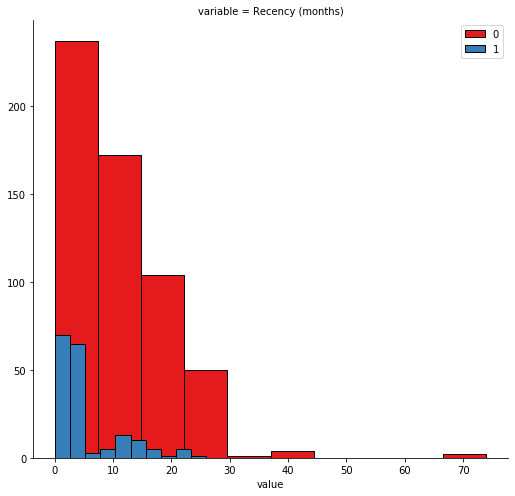

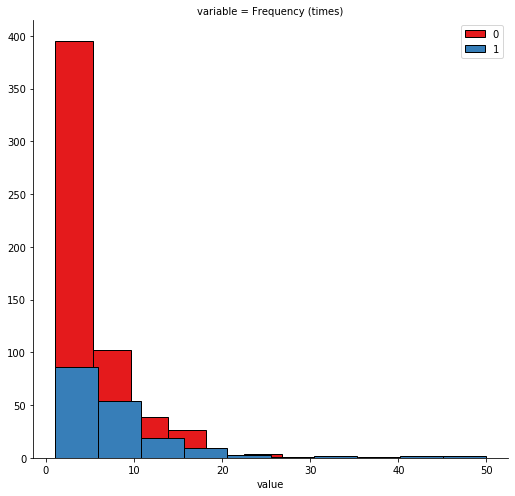

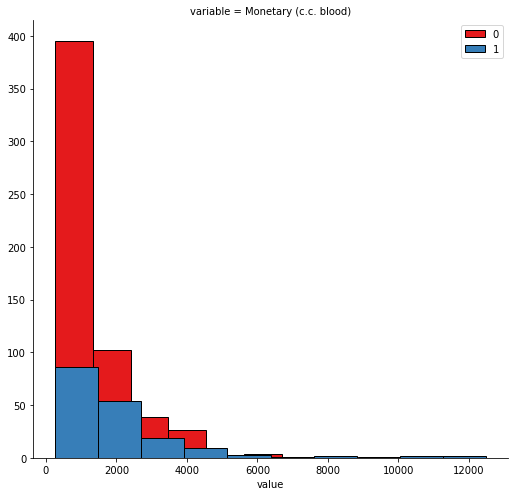

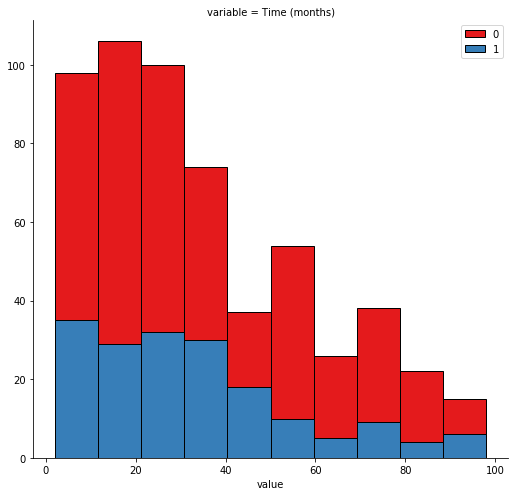

In [21]:
# Plot distribution among features
for col in transfusion.drop(columns='target').columns:
    df = pd.melt(transfusion[[col,'target']], id_vars='target', value_vars=col, value_name='value')
    g = sns.FacetGrid(df,col="variable", hue="target", palette="Set1", col_wrap=2, height = 7)
    g.map(plt.hist, 'value', bins =10,ec="k")
    g.axes[-1].legend()


## 5. Checking target incidence
<p>We want to predict whether or not the same donor will give blood the next time the vehicle comes to campus. The model for this is a binary classifier, meaning that there are only 2 possible outcomes:</p>
<ul>
<li><code>0</code> - the donor will not give blood</li>
<li><code>1</code> - the donor will give blood</li>
</ul>
<p>Target incidence is defined as the number of cases of each individual target value in a dataset. That is, how many 0s in the target column compared to how many 1s? Target incidence gives us an idea of how balanced (or imbalanced) is our dataset.</p>

In [5]:
# Print target incidence proportions, rounding output to 3 decimal places
transfusion.target.value_counts(normalize=True).round(3)

0    0.762
1    0.238
Name: target, dtype: float64

## 6. Splitting transfusion into train and test datasets
<p>We'll now use <code>train_test_split()</code> method to split <code>transfusion</code> DataFrame.</p>
<p>Target incidence informed us that in our dataset <code>0</code>s appear 76% of the time. We want to keep the same structure in train and test datasets, i.e., both datasets must have 0 target incidence of 76%. This is very easy to do using the <code>train_test_split()</code> method from the <code>scikit learn</code> library - all we need to do is specify the <code>stratify</code> parameter. In our case, we'll stratify on the <code>target</code> column.</p>

In [6]:
# Import train_test_split method
from sklearn.model_selection import train_test_split

# Split transfusion DataFrame into
# X_train, X_test, y_train and y_test datasets,
# stratifying on the `target` column
X_train, X_test, y_train, y_test = train_test_split(
    transfusion.drop(columns='target'),
    transfusion.target,
    test_size=0.25,
    random_state=42,
    stratify=transfusion.target
)

# Print out the first 2 rows of X_train
X_train.shape

(561, 4)

## 7. Selecting model using TPOT
<p><a href="https://github.com/EpistasisLab/tpot">TPOT</a> is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.</p>
<p><img src="https://assets.datacamp.com/production/project_646/img/tpot-ml-pipeline.png" alt="TPOT Machine Learning Pipeline"></p>
<p>TPOT will automatically explore hundreds of possible pipelines to find the best one for our dataset. Note, the outcome of this search will be a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">scikit-learn pipeline</a>, meaning it will include any pre-processing steps as well as the model.</p>
<p>We are using TPOT to help us zero in on one model that we can then explore and optimize further.</p>

In [7]:
# Import TPOTClassifier and roc_auc_score
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score, log_loss

# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring= 'roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(X_train, y_train)

# AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')

# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}.{transform}')

Generation 1 - Current best internal CV score: 0.7424354492343548
Generation 2 - Current best internal CV score: 0.742608727848126
Generation 3 - Current best internal CV score: 0.742608727848126
Generation 4 - Current best internal CV score: 0.742608727848126
Generation 5 - Current best internal CV score: 0.7437395988011584

Best pipeline: LogisticRegression(StandardScaler(VarianceThreshold(input_matrix, threshold=0.05)), C=0.1, dual=False, penalty=l2)

AUC score: 0.7866

Best pipeline steps:
1.VarianceThreshold(threshold=0.05)
2.StandardScaler(copy=True, with_mean=True, with_std=True)
3.LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


## 8. Checking the variance
<p>TPOT picked <code>LogisticRegression</code> as the best model for our dataset with no pre-processing steps, giving us the AUC score of 0.7850. This is a great starting point. Let's see if we can make it better.</p>
<p>One of the assumptions for linear regression models is that the data and the features we are giving it are related in a linear fashion, or can be measured with a linear distance metric. If a feature in our dataset has a high variance that's an order of magnitude or more greater than the other features, this could impact the model's ability to learn from other features in the dataset.</p>
<p>Correcting for high variance is called normalization. It is one of the possible transformations you do before training a model. Let's check the variance to see if such transformation is needed.</p>

In [8]:
# X_train's variance, rounding the output to 3 decimal places
X_train.var().round(3)

Recency (months)              66.929
Frequency (times)             33.830
Monetary (c.c. blood)    2114363.700
Time (months)                611.147
dtype: float64

## 9. Log normalization
<p><code>Monetary (c.c. blood)</code>'s variance is very high in comparison to any other column in the dataset. This means that, unless accounted for, this feature may get more weight by the model (i.e., be seen as more important) than any other feature.</p>
<p>One way to correct for high variance is to use log normalization.</p>

In [9]:
# Import numpy
import numpy as np

# Copy X_train and X_test into X_train_normed and X_test_normed
X_train_normed, X_test_normed = X_train.copy(), X_test.copy()

# Specify which column to normalize
col_to_normalize = 'Monetary (c.c. blood)'

# Log normalization
for df_ in [X_train_normed, X_test_normed]:
    # Add log normalized column
    df_['monetary_log'] = np.log(df_[col_to_normalize])
    # Drop the original column
    df_.drop(columns=col_to_normalize, inplace=True)

# Check the variance for X_train_normed
X_train_normed.var().round(3)

Recency (months)      66.929
Frequency (times)     33.830
Time (months)        611.147
monetary_log           0.837
dtype: float64

## 10. Training the linear regression model
<p>The variance looks much better now. Notice that now <code>Time (months)</code> has the largest variance, but it's not the <a href="https://en.wikipedia.org/wiki/Order_of_magnitude">orders of magnitude</a> higher than the rest of the variables, so we'll leave it as is.</p>
<p>We are now ready to train the linear regression model.</p>

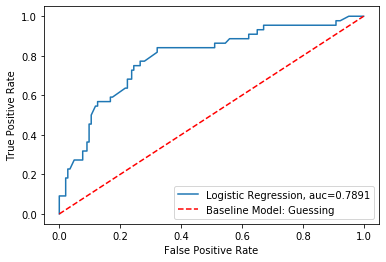


AUC score: 0.5463

Log Loss: 0.4476


In [14]:
# Importing modules
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import log_loss

# Instantiate LogisticRegression
logreg = linear_model.LogisticRegression(
    solver='liblinear',
    random_state=42
)

# Train the model
logreg.fit(X_train_normed, y_train)
y_pred = logreg.predict(X_test_normed)
# AUC score for tpot model
logreg_auc_score = roc_auc_score(y_test, logreg.predict(X_test_normed))


y_pred_proba = logreg.predict_proba(X_test_normed)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc.round(4)))
plt.plot([0, 1], [0, 1],'r--', label = 'Baseline Model: Guessing')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


print(f'\nAUC score: {logreg_auc_score:.4f}')
print(f'\nLog Loss: {log_loss(y_test, logreg.predict_proba(X_test_normed)[:, 1]):.4f}')

Accuracy: 0.7754010695187166
Precision: 0.625
Recall: 0.11363636363636363


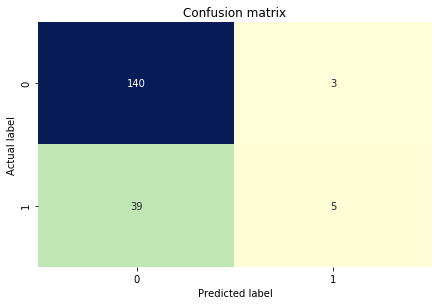

In [17]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes

# create heatmap
ax = sns.heatmap(cnf_matrix, annot = True ,  cmap="YlGnBu",  fmt ='d', cbar = False)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

## 11. Conclusion
<p>The demand for blood fluctuates throughout the year. As one <a href="https://www.kjrh.com/news/local-news/red-cross-in-blood-donation-crisis">prominent</a> example, blood donations slow down during busy holiday seasons. An accurate forecast for the future supply of blood allows for an appropriate action to be taken ahead of time and therefore saving more lives.</p>
<p>In this notebook, we explored automatic model selection using TPOT and AUC score we got was 0.7850. This is better than simply choosing <code>0</code> all the time (the target incidence suggests that such a model would have 76% success rate). We then log normalized our training data and improved the AUC score by 0.5%. In the field of machine learning, even small improvements in accuracy can be important, depending on the purpose.</p>
<p>Another benefit of using logistic regression model is that it is interpretable. We can analyze how much of the variance in the response variable (<code>target</code>) can be explained by other variables in our dataset.</p>

In [ ]:
# Importing itemgetter
from operator import itemgetter

# Sort models based on their AUC score from highest to lowest
sorted(
    [('tpot', tpot_auc_score), ('logreg', logreg_auc_score)],
    key=itemgetter(1),
    reverse=True
)